# Task 2: Continuous Actions with PPO Algorithm

The PPO algorithm was extended to handle continuous action spaces. Multiple experiments were conducted with varied hyperparameter configurations to assess performance differences. Evaluation rewards were recorded using TensorBoard to monitor training progress.

**Author:** Yuxian Zuo

In [ ]:
import gymnasium as gym
import highway_env
import torch
import pickle
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

from torch.utils.tensorboard import SummaryWriter

from PPOContinuous import PPOContinuous

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def eval_agent(agent, env, n_sim=10):
    """
    Monte Carlo evaluation using deterministic action.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)

    for i in range(n_sim):
        state, _ = env_copy.reset()
        done = False
        total_reward = 0

        while not done:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                state_tensor = state_tensor.view(state_tensor.size(0), -1)
                mean, _ = agent.actor(state_tensor)
                action = mean.squeeze().cpu().numpy()

            state, reward, terminated, truncated, _ = env_copy.step(action)
            total_reward += reward
            done = terminated or truncated

        episode_rewards[i] = total_reward

    return episode_rewards

In [4]:
def train(env, agent, N_episodes, eval_every=50, reward_threshold=100, n_eval=10, save_prefix="ppo_checkpoint"):
    total_time = 0
    losses = []
    reward_history = []
    best_avg_reward = -float("inf")

    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()

        while not done:
            action, log_prob = agent.get_action(state)
            env_action = np.array(action, dtype=np.float32).flatten()
            next_state, reward, terminated, truncated, _ = env.step(env_action)

            done = terminated or truncated
            agent.update(state, action, reward, done, next_state)

            state = next_state
            total_time += 1

        # Record loss only if a full update was just performed
        if hasattr(agent, "last_joint_loss") and (agent.n_eps % agent.episode_batch_size == 0):
            losses.append(agent.last_joint_loss)

        # Evaluate and checkpoint
        if (ep + 1) % eval_every == 0:
            rewards = eval_agent(agent, env, n_sim=n_eval)
            avg_reward = np.mean(rewards)
            reward_history.append(avg_reward)
            print(f"episode {ep + 1}: eval reward = {avg_reward:.2f}")

            if agent.writer:
                agent.writer.add_scalar("eval/reward", avg_reward, ep + 1)

            # Save regular checkpoint
            # torch.save(agent.actor.state_dict(), f"{save_prefix}_actor_ep{ep+1}.pth")
            # torch.save(agent.critic.state_dict(), f"{save_prefix}_critic_ep{ep+1}.pth")

            # Save best model so far
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                torch.save(agent.actor.state_dict(), f"{save_prefix}_actor_best.pth")
                torch.save(agent.critic.state_dict(), f"{save_prefix}_critic_best.pth")
                print(f"Saved new best model (avg reward = {avg_reward:.2f})")

            if avg_reward >= reward_threshold:
                print("Reward threshold reached! Training complete.")
                break

    return losses, reward_history

In [5]:
with open("configs/highway_continuous_config.pkl", "rb") as f:
    config = pickle.load(f)

# Setup environment
env = gym.make("highway-fast-v0", render_mode=None, config=config)

# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [6]:
N_episodes=1000
eval_every=50

# Set up experiment name
writer = SummaryWriter(log_dir="runs/ppo_exp4")

# Instantiate agent
agent = PPOContinuous(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    episode_batch_size=30,
    actor_learning_rate=3e-5,
    critic_learning_rate=1e-3,
    lambda_=0.95,
    eps_clip=0.1,
    writer=writer,
    K_epochs=3,
    minibatch_size=128,
    c1=0.5,
    c2=0.001
)

# Send models to GPU
agent.actor = agent.actor.to(device)
agent.critic = agent.critic.to(device)

In [7]:
# Run training
losses, rewards = train(env, agent, N_episodes=N_episodes, eval_every=eval_every,
                        reward_threshold=100, n_eval=50, save_prefix="ppo_exp4")

episode 50: eval reward = 2.86
Saved new best model (avg reward = 2.86)
episode 100: eval reward = 3.11
Saved new best model (avg reward = 3.11)
episode 150: eval reward = 3.60
Saved new best model (avg reward = 3.60)
episode 200: eval reward = 3.77
Saved new best model (avg reward = 3.77)
episode 250: eval reward = 3.33
episode 300: eval reward = 2.93
episode 350: eval reward = 3.98
Saved new best model (avg reward = 3.98)
episode 400: eval reward = 1.87
episode 450: eval reward = 0.56
episode 500: eval reward = 0.43
episode 550: eval reward = 0.62
episode 600: eval reward = 3.27
episode 650: eval reward = 3.78
episode 700: eval reward = 6.21
Saved new best model (avg reward = 6.21)
episode 750: eval reward = 12.34
Saved new best model (avg reward = 12.34)
episode 800: eval reward = 9.80
episode 850: eval reward = 4.44
episode 900: eval reward = 6.28
episode 950: eval reward = 4.78
episode 1000: eval reward = 14.92
Saved new best model (avg reward = 14.92)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

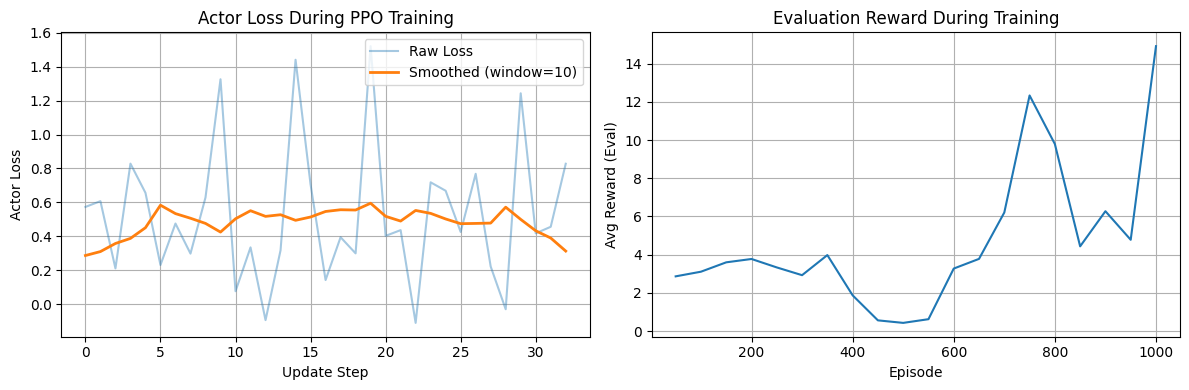

In [8]:
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(losses, label="Raw Loss", alpha=0.4)

# Smoothed loss curve
window = 10
if len(losses) >= window:
    smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='same')
    plt.plot(smoothed_losses, label=f"Smoothed (window={window})", linewidth=2)

plt.xlabel("Update Step")
plt.ylabel("Actor Loss")
plt.title("Actor Loss During PPO Training")
plt.legend()
plt.grid()

# Evaluation reward
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(rewards)+1) * eval_every, rewards, label="Eval Reward")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (Eval)")
plt.title("Evaluation Reward During Training")
plt.grid()

plt.tight_layout()
plt.show()

In [9]:
agent.actor.load_state_dict(torch.load("ppo_exp4_actor_best.pth", map_location=device, weights_only=True))
agent.critic.load_state_dict(torch.load("ppo_exp4_critic_best.pth", map_location=device, weights_only=True))

<All keys matched successfully>

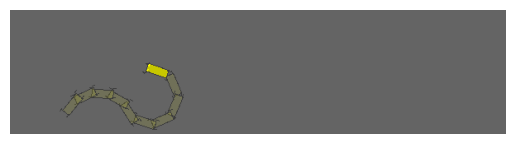

In [10]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)
state, _ = env.reset()
done = False

for _ in range(100):
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).flatten().unsqueeze(0).to(device) 
        mean, std = agent.actor(state_tensor)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample().cpu().numpy().flatten()  # sampled continuous action

    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    clear_output(wait=True)
    plt.show()
    time.sleep(0.1)
    
env.close()

Download evaluation reward data from TensorBoard for plotting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

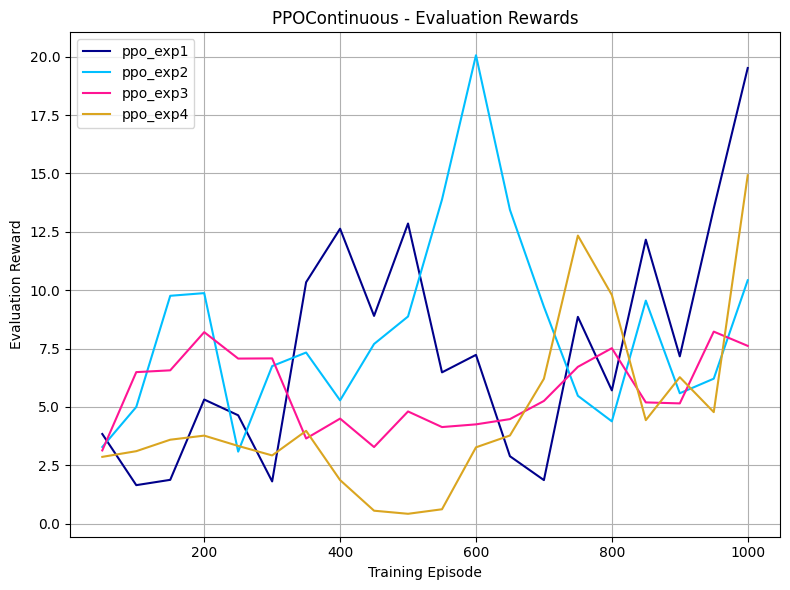

In [ ]:
log_dir = "plot_runs/"

experiments = {
    "ppo_exp1": "darkblue",
    "ppo_exp2": "deepskyblue",
    "ppo_exp3": "deeppink",
    "ppo_exp4": "goldenrod",
}

plt.figure(figsize=(8, 6))

for exp_name, color in experiments.items():
    file_path = os.path.join(log_dir, f"run-{exp_name}-tag-eval_reward.csv")
    df = pd.read_csv(file_path)
    
    # Extract step and value columns
    steps = df['Step']
    rewards = df['Value']

    plt.plot(steps, rewards, label=exp_name, color=color)

plt.xlabel("Training Episode")
plt.ylabel("Evaluation Reward")
plt.title("PPOContinuous - Evaluation Rewards")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()